In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TASK 1


In [24]:
def gen_data(n=5000):
    X=np.random.uniform(0,np.pi,(n,10))
    cond=np.sum(np.sin(X[:,0:5]),axis=1)
    y=np.where(cond>=2.5,1,0)
    return X,y

In [31]:
X,y=gen_data()

In [32]:
np.unique(y,return_counts=True)

(array([0, 1]), array([ 825, 4175]))

# Task 2

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
X[:,i]

array([[2.45210588, 1.4642253 , 2.45210588, 1.30262595, 1.4642253 ],
       [2.25370325, 1.88030288, 2.25370325, 0.44430101, 1.88030288],
       [1.83897134, 0.71677342, 1.83897134, 1.74015654, 0.71677342],
       ...,
       [2.57692362, 1.32891513, 2.57692362, 1.4259706 , 1.32891513],
       [0.33231542, 2.85777269, 0.33231542, 1.20303375, 2.85777269],
       [0.67624698, 0.44579645, 0.67624698, 2.87321699, 0.44579645]],
      shape=(5000, 5))

In [56]:
class RandomSubspaceClassifier:
    def __init__(self,B=100,m=5):
        self.B=B
        self.m=m
        self.classifiers=[]
        self.subspaces=[]
    def fit(self,X,y):
        n_features=X.shape[1]
        for b in range(self.B):
            feats=np.random.choice(n_features,self.m)
            X_new=X[:,feats]
            model=DecisionTreeClassifier(max_depth=3)
            model.fit(X_new,y)
            self.classifiers.append(model)
            self.subspaces.append(feats)
        return self
    
    def predict(self,X):
        n_samples=X.shape[0]
        y_pred=np.zeros(n_samples)
        for (cls,sub) in zip(self.classifiers,self.subspaces):
            y_pred+=cls.predict(X[:,sub])
        y=np.where(y_pred>=self.B/2,1,0)
        return y

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [58]:
model=RandomSubspaceClassifier().fit(X_train,y_train)

In [59]:
model.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [62]:
from sklearn.metrics import accuracy_score

In [63]:
def plot(X_train,X_test,y_train,y_test):
    accs=[]
    n=X_train.shape[1]
    ms=[]
    for m in range(1,n+1):
        model=RandomSubspaceClassifier(m=m)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        accs.append(accuracy_score(y_test,y_pred))
        ms.append(m)
        
    plt.figure(figsize=(10,8))
    plt.title("accuracy of RSM vs subspace size")
    plt.xlabel("subspace size")
    plt.ylabel("accuracy")
    plt.plot(ms,accs)
    plt.grid(True)
    plt.show()
        

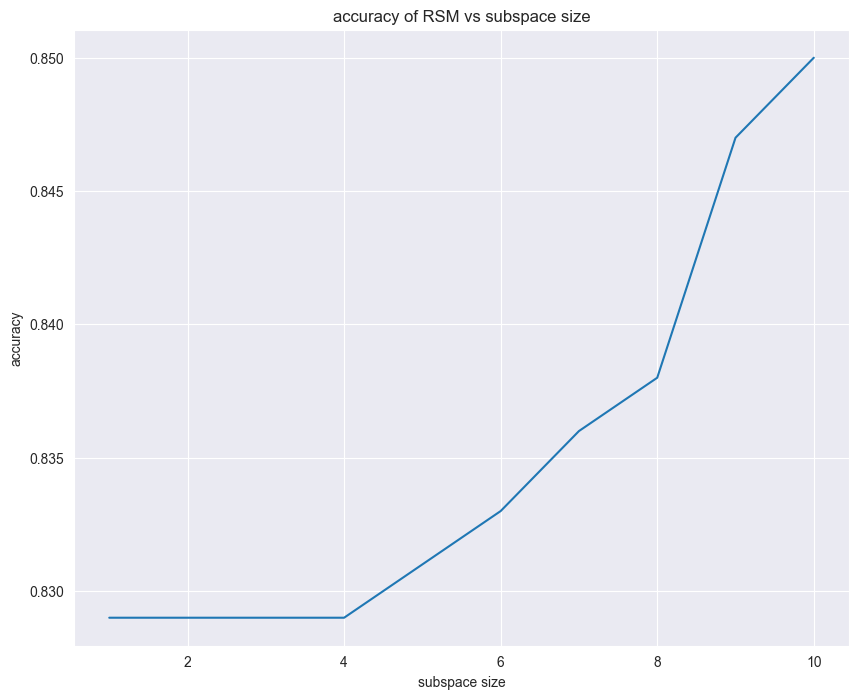

In [64]:
plot(X_train,X_test,y_train,y_test)